On this Notebook, we will focus on balanced dataset for classification. Before, that let's experiment on unbalanced with duplicates removed


In [1]:
#library import
import pandas as pd # for data manipulation and analysis
import numpy as np # for scientific computing with Python
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline
import seaborn as sns # for advanced visualization

Imported unbalanced dataset has had it's stopwords and punctuation removed

In [2]:
from collections import Counter

df= pd.read_csv('../Data/Preprocessed/unbal_word2vec.csv')
df_unbal_word2vec= df.copy()

# 70:30 split
from sklearn.model_selection import train_test_split

# Split into X and y
X = df_unbal_word2vec.drop('Target', axis=1)  # all columns except the 'Target' column
y = df_unbal_word2vec['Target']              # the 'Target' column

X_train_unbal, X_test_unbal, y_train_unbal, y_test_unbal= train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)

print(f'Train split Shape: {Counter(y_train_unbal)}')
print(f'Test split Shape: {Counter(y_test_unbal)}')


Train split Shape: Counter({1: 950, 0: 631, 2: 175, 5: 111, 4: 76, 3: 58})
Test split Shape: Counter({1: 408, 0: 270, 2: 75, 5: 48, 4: 32, 3: 25})


In [3]:
y_train_unbal.count()


2001

In [4]:
y_test_unbal.count()

858

In [5]:
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [6]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_unbal), y=y_train_unbal)
class_weights_dict = dict(enumerate(class_weights))

# Training SVC

svc = SVC(probability=True, class_weight=class_weights_dict, random_state=42)
svc.fit(X_train_unbal,y_train_unbal)

SVC(class_weight={0: 0.528526148969889, 1: 0.3510526315789474,
                  2: 1.9057142857142857, 3: 5.75, 4: 4.3881578947368425,
                  5: 3.0045045045045047},
    probability=True, random_state=42)

In [7]:
# Function to evaluate model and returns target predictions 
def make_scores(model, features, target):
    model_pred = model.predict(features)

    print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(model_pred , target))) 

    roc_auc = metrics.roc_auc_score(target , model.predict_proba(features), multi_class='ovr')
    print('AUC : {0:0.5f}'.format(roc_auc))

    print('Precision : {0:0.5f}'.format(metrics.precision_score(target , model_pred, average='macro')))
    print('Recall : {0:0.5f}'.format(metrics.recall_score(target , model_pred, average='macro')))
    print('F1 : {0:0.5f}'.format(metrics.f1_score(target , model_pred, average='macro')))
    print(classification_report(target, model_pred))
    
    return model_pred

# Scores of SVC
svc_pred=make_scores(svc, X_test_unbal, y_test_unbal)

Accuracy :0.53380
AUC : 0.80396
Precision : 0.36128
Recall : 0.40607
F1 : 0.36781
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       270
           1       0.69      0.50      0.58       408
           2       0.21      0.40      0.28        75
           3       0.10      0.12      0.11        25
           4       0.21      0.41      0.27        32
           5       0.17      0.29      0.21        48

    accuracy                           0.53       858
   macro avg       0.36      0.41      0.37       858
weighted avg       0.61      0.53      0.56       858



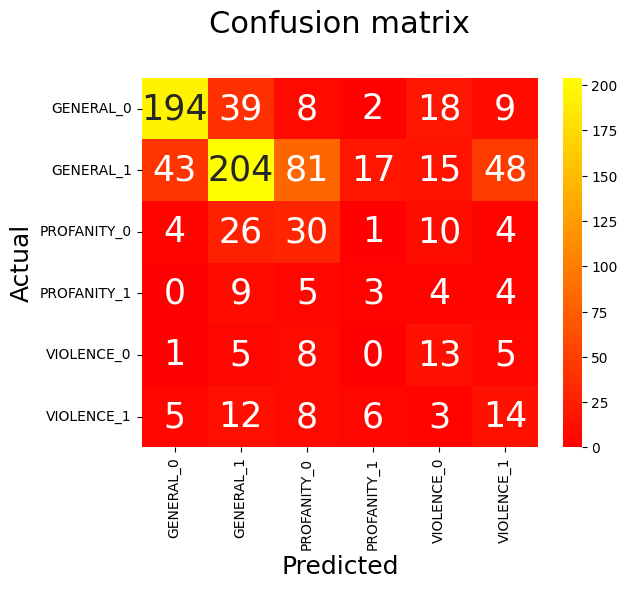

In [8]:
# Heatmap for Confusion Matrix
def make_confusion_matrix(target, prediction):
    cnf_matrix = metrics.confusion_matrix(target,prediction)
    cnf_matrix_df = pd.DataFrame(cnf_matrix,
                         index = ['GENERAL_0','GENERAL_1','PROFANITY_0','PROFANITY_1','VIOLENCE_0','VIOLENCE_1'], 
                         columns = ['GENERAL_0','GENERAL_1','PROFANITY_0','PROFANITY_1','VIOLENCE_0','VIOLENCE_1'])
    p = sns.heatmap(cnf_matrix_df, annot=True, annot_kws={"size": 25}, cmap="autumn" ,fmt='g')

    plt.title('Confusion matrix', y=1.1, fontsize = 22)
    plt.ylabel('Actual',fontsize = 18)
    plt.xlabel('Predicted',fontsize = 18)
    plt.show()

# Confusion Matrix for SVC
make_confusion_matrix(y_test_unbal,svc_pred)

## Let's Focus on Balancing
- We'll undersample general class, while oversampling minorities
- For undersampling, experiments are done on: NeighbourhoodCleaningRule(NCR) and CondensedNearestNeighbour(CNN)
- For oversampling, experiments are done on: Synthetic Minority Over-sampling Technique(SMOTE) and Adaptive Synthetic Sampling(ADASYN)

## NCR and SMOTE

check Create_embeddings to know target encodeding
- GENERAL_0: 0
- GENERAL_1: 1
- PROFANITY_0: 2
- PROFANITY_1: 3
- VIOLENCE_0: 4
- VIOLENCE_1: 5


In [9]:
# Combining X_train_unbal and y_train_unbal into a single DataFrame
df_train_unbal = pd.concat([X_train_unbal, y_train_unbal], axis=1)

df_train_unbal.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Target
238,0.475356,-0.220736,-0.268322,0.718342,-0.315466,0.650326,0.318668,0.446808,-0.043805,-0.887722,...,-0.996795,0.475885,0.097101,0.287338,-0.228005,-0.049033,0.165992,0.872332,0.266778,1
2111,1.671746,-0.279206,-0.589234,0.318984,-0.185866,0.295796,0.391102,0.658728,-0.546694,-0.400759,...,-0.618817,1.014680,-0.867367,-0.330724,-0.234953,-0.153289,-0.017778,0.985558,-0.365500,0
60,-0.242277,0.863279,0.711929,-1.553150,-0.845970,1.335614,-0.884575,-0.001486,-0.013503,-1.053877,...,-1.466598,-0.934075,0.835120,0.452002,-0.237655,-0.702479,0.563444,-0.227416,0.964513,1
2383,1.253523,-0.585731,-0.693199,-0.323983,0.499648,-0.055364,-0.671756,0.335735,0.653795,-0.127687,...,0.274127,-0.401978,0.297340,0.714342,-0.045665,-0.645622,-0.597424,0.426839,0.801014,2
1310,0.291030,0.186152,-0.409204,0.011403,-0.600386,0.620061,0.273095,-0.570770,-0.483634,-0.463391,...,-0.203489,0.196177,0.517887,0.782675,-0.038258,-0.814826,-0.070437,-0.312081,0.483857,1


In [10]:
df_train_unbal.loc[:, 'Target'].value_counts()

Target
1    950
0    631
2    175
5    111
4     76
3     58
Name: count, dtype: int64

In [11]:
# First undersampling GENERAL 
from imblearn.under_sampling import NeighbourhoodCleaningRule

ncr = NeighbourhoodCleaningRule()

# Filtering out 'GENERAL' class instances
general_samples = df_train_unbal[df_train_unbal['Target'].isin([0, 1])]
X_general, y_general = general_samples.drop(['Target'], axis=1), general_samples['Target']

# Resampling
X_general_resampled, y_general_resampled= ncr.fit_resample(X_general, y_general)

# Creating a new DataFrame with cleaned 'GENERAL' and 'PROFANITY_0' samples
df_general = pd.DataFrame(
    data=X_general_resampled,
    columns=X_general.columns
).assign(Target=y_general_resampled.values)

df_general = df_general.copy() #To avoid fragmentation

# Combining with other classes
df_undersampled= pd.concat([df_train_unbal[df_train_unbal['Target'].isin([2, 3, 4, 5])], df_general])

In [12]:
df_general.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Target
0,1.671746,-0.279206,-0.589234,0.318984,-0.185866,0.295796,0.391102,0.658728,-0.546694,-0.400759,...,-0.618817,1.014680,-0.867367,-0.330724,-0.234953,-0.153289,-0.017778,0.985558,-0.365500,0
1,-0.242277,0.863279,0.711929,-1.553150,-0.845970,1.335614,-0.884575,-0.001486,-0.013503,-1.053877,...,-1.466598,-0.934075,0.835120,0.452002,-0.237655,-0.702479,0.563444,-0.227416,0.964513,1
2,0.291030,0.186152,-0.409204,0.011403,-0.600386,0.620061,0.273095,-0.570770,-0.483634,-0.463391,...,-0.203489,0.196177,0.517887,0.782675,-0.038258,-0.814826,-0.070437,-0.312081,0.483857,1
3,0.308740,0.148269,-0.407579,-1.052733,-0.087116,0.235532,-0.534749,0.476347,-0.244669,-0.888457,...,0.250593,0.653034,0.788585,-0.302696,0.036329,0.151428,0.015212,0.595444,-0.536053,0
4,-0.815330,-0.586446,-0.771185,-0.315594,0.299145,-0.028787,-0.298019,0.339174,0.126081,-0.909948,...,0.001059,0.142871,0.136753,0.735089,0.671926,-0.663662,-0.281290,-0.624113,0.569283,1


In [13]:
# Checking the shape now

df_general.loc[:,"Target"].value_counts()

Target
0    631
1    584
Name: count, dtype: int64

In [14]:
df_undersampled.loc[:,"Target"].value_counts()

Target
0    631
1    584
2    175
5    111
4     76
3     58
Name: count, dtype: int64

## This is still high for other minorities, so we will use randomundersampling

In [15]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = {
    0: 200,  # GENERAL_0 aiming for 200
    1: 200,   # GENERAL_1 aiming for 200
}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)  
X_general_resampled_rus, y_general_resampled_rus = rus.fit_resample(X_general_resampled, y_general_resampled)

# DataFrame for this operation

df_general = pd.DataFrame(
    data=X_general_resampled_rus,
    columns=X_general.columns
).assign(Target=y_general_resampled_rus.values)

df_general.loc[:,"Target"].value_counts()


Target
0    200
1    200
Name: count, dtype: int64

In [16]:
# Combining with other classes
df_undersampled= pd.concat([df_train_unbal[df_train_unbal['Target'].isin([2, 3, 4, 5])], df_general])

df_undersampled.loc[:,"Target"].value_counts()

Target
0    200
1    200
2    175
5    111
4     76
3     58
Name: count, dtype: int64

In [17]:
df_undersampled.count()

0         820
1         820
2         820
3         820
4         820
         ... 
296       820
297       820
298       820
299       820
Target    820
Length: 301, dtype: int64

### now we try SMOTE oversampling


In [18]:
df_undersampled.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Target
2383,1.253523,-0.585731,-0.693199,-0.323983,0.499648,-0.055364,-0.671756,0.335735,0.653795,-0.127687,...,0.274127,-0.401978,0.297340,0.714342,-0.045665,-0.645622,-0.597424,0.426839,0.801014,2
2524,0.355159,-1.576040,-0.123739,0.742014,0.744486,0.856528,0.047161,0.821650,0.227088,-1.577905,...,-0.513213,-1.002122,-0.138978,0.320832,-0.466546,-1.325251,-0.779911,0.214717,-0.541697,3
2498,-0.510436,-0.893263,-0.970838,-0.262496,0.782132,0.825117,-0.500983,0.487266,-0.537480,-0.548096,...,0.197424,0.262899,1.306628,0.303546,-0.093703,0.159493,-0.358521,-0.103838,-0.559444,3
2756,0.067474,-0.485017,0.178584,-0.189378,0.350059,0.992095,0.094451,0.098488,-0.102522,-1.144166,...,-0.563820,-1.625187,-0.257373,0.474959,0.410125,-0.690676,-0.123380,-0.207194,-0.118349,5
2692,0.567095,-0.603252,-0.676466,1.101681,-0.169066,0.397838,0.940538,0.772277,0.001420,-0.850388,...,-0.504952,-0.027641,-0.072673,1.524484,0.210365,0.089879,0.143693,-0.060136,0.729383,5


In [19]:
from imblearn.over_sampling import SMOTE

X_undersampled, y_undersampled =df_undersampled.drop(['Target'], axis=1), df_undersampled['Target']

# Define the sampling strategy for SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_ncr_smote, y_ncr_smote = smote.fit_resample(X_undersampled, y_undersampled)


In [20]:
y_ncr_smote.value_counts()

Target
2    200
3    200
5    200
4    200
0    200
1    200
Name: count, dtype: int64

Now we Train model


Accuracy :0.47669
AUC : 0.77062
Precision : 0.33108
Recall : 0.37875
F1 : 0.33073
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       270
           1       0.70      0.37      0.49       408
           2       0.19      0.39      0.26        75
           3       0.08      0.12      0.10        25
           4       0.17      0.34      0.23        32
           5       0.15      0.31      0.20        48

    accuracy                           0.48       858
   macro avg       0.33      0.38      0.33       858
weighted avg       0.59      0.48      0.50       858



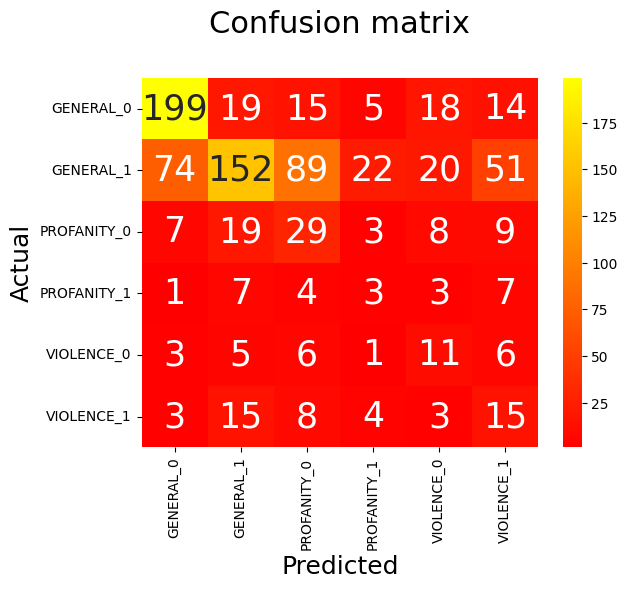

In [21]:
# Training SVC without class_weight

svc2 = SVC(probability=True, random_state=42)
svc2.fit(X_ncr_smote,y_ncr_smote)

# Scores of SVC2
svc2_pred=make_scores(svc2, X_test_unbal, y_test_unbal)

# Confusion Matrix for SVC2
make_confusion_matrix(y_test_unbal,svc2_pred)

In [22]:
# Let's try PCA too

import pandas as pd
from sklearn.decomposition import PCA

# Define the number of principal components
n_components = 50
pca = PCA(n_components=n_components)

# Apply PCA on the balanced training set 
X_ncr_smote_pca = pca.fit_transform(X_ncr_smote)

# Transform the test sets using the same PCA model
X_test_unbal_pca = pca.transform(X_test_unbal)

# Convert PCA results to DataFrames
X_ncr_smote_pca_df = pd.DataFrame(X_ncr_smote_pca, columns=[f"PC{i+1}" for i in range(n_components)])
X_test_unbal_pca_df = pd.DataFrame(X_test_unbal_pca, columns=[f"PC{i+1}" for i in range(n_components)])

Accuracy :0.43357
AUC : 0.74850
Precision : 0.31260
Recall : 0.34558
F1 : 0.30065
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       270
           1       0.70      0.33      0.45       408
           2       0.17      0.32      0.22        75
           3       0.07      0.20      0.11        25
           4       0.15      0.28      0.20        32
           5       0.10      0.25      0.14        48

    accuracy                           0.43       858
   macro avg       0.31      0.35      0.30       858
weighted avg       0.58      0.43      0.47       858



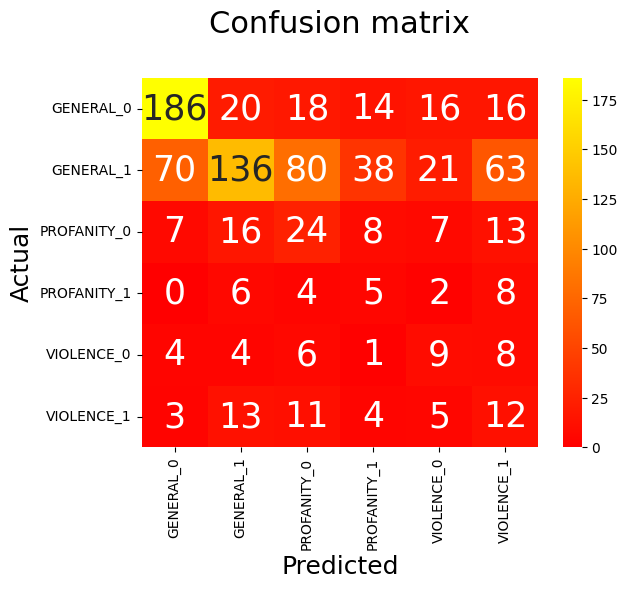

In [23]:
# Training SVC_pca

svc2_pca = SVC(probability=True, random_state=42)
svc2_pca.fit(X_ncr_smote_pca,y_ncr_smote)

# Scores of SVC
svc2_pred=make_scores(svc2_pca, X_test_unbal_pca, y_test_unbal)

# Confusion Matrix for SVC
make_confusion_matrix(y_test_unbal,svc2_pred)

Accuracy :0.38112
AUC : 0.68150
Precision : 0.29162
Recall : 0.31581
F1 : 0.27090
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       270
           1       0.59      0.29      0.39       408
           2       0.12      0.32      0.18        75
           3       0.02      0.04      0.03        25
           4       0.13      0.31      0.19        32
           5       0.13      0.35      0.19        48

    accuracy                           0.38       858
   macro avg       0.29      0.32      0.27       858
weighted avg       0.54      0.38      0.43       858



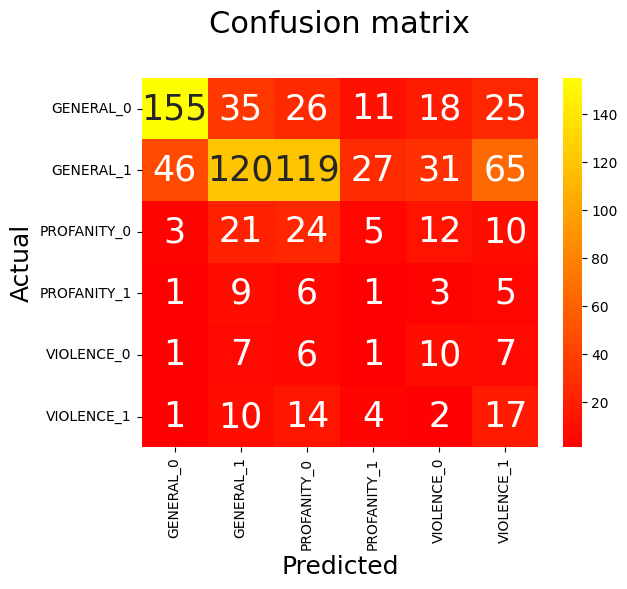

In [24]:
# Tying AdaBoostClassifier

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42) 
ada.fit(X_ncr_smote, y_ncr_smote)

ada_pred= make_scores(ada, X_test_unbal, y_test_unbal)
make_confusion_matrix(y_test_unbal,ada_pred)

## NCR and ADAYSN

In [26]:
y_undersampled.value_counts()

Target
0    200
1    200
2    175
5    111
4     76
3     58
Name: count, dtype: int64

In [27]:
from imblearn.over_sampling import ADASYN

# Define the sampling strategy for SMOTE
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_ncr_adasyn, y_ncr_adasyn = adasyn.fit_resample(X_undersampled, y_undersampled)

y_ncr_adasyn.value_counts()

Target
0    200
1    200
3    199
2    175
5    111
4     76
Name: count, dtype: int64

Accuracy :0.50816
AUC : 0.78345
Precision : 0.37132
Recall : 0.37880
F1 : 0.34260
              precision    recall  f1-score   support

           0       0.68      0.76      0.72       270
           1       0.70      0.42      0.53       408
           2       0.23      0.49      0.31        75
           3       0.09      0.28      0.13        25
           4       0.36      0.12      0.19        32
           5       0.17      0.19      0.18        48

    accuracy                           0.51       858
   macro avg       0.37      0.38      0.34       858
weighted avg       0.59      0.51      0.53       858



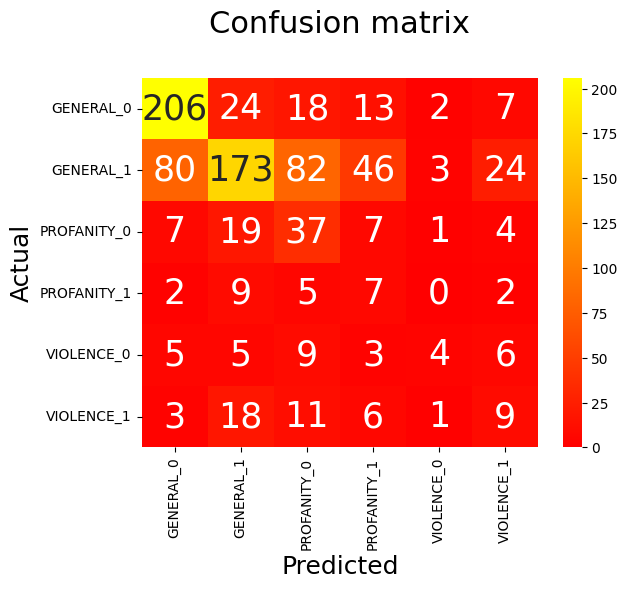

In [28]:
svc3 = SVC(probability=True, random_state=42)
svc3.fit(X_ncr_adasyn,y_ncr_adasyn)

# Scores of SVC2
svc3_pred=make_scores(svc3, X_test_unbal, y_test_unbal)

# Confusion Matrix for SVC2
make_confusion_matrix(y_test_unbal,svc3_pred)

# CNN undersampling and SMOTE

In [29]:
y_general.value_counts()

Target
1    950
0    631
Name: count, dtype: int64

In [30]:
# First undersampling GENERAL using CNN
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=42)  

# Resampling
X_cnn_undersampled, y_cnn_undersampled= cnn.fit_resample(X_general, y_general)

# Creating a new DataFrame with cleaned 'GENERAL' and 'PROFANITY_0' samples
df_general2 = pd.DataFrame(
    data=X_cnn_undersampled,
    columns=X_general.columns
).assign(Target=y_cnn_undersampled.values)

df_general2 = df_general2.copy() #To avoid fragmentation

# Combining with other classes
df_cnn= pd.concat([df_train_unbal[df_train_unbal['Target'].isin([2, 3, 4, 5])], df_general2])

In [31]:
df_cnn.loc[:,"Target"].value_counts()

Target
0    631
1    446
2    175
5    111
4     76
3     58
Name: count, dtype: int64

In [32]:
# RandomunderSampling

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)  
X_cnn_resampled_rus, y_cnn_resampled_rus = rus.fit_resample(X_cnn_undersampled, y_cnn_undersampled)

# DataFrame for this operation

df_general2 = pd.DataFrame(
    data=X_cnn_resampled_rus,
    columns=X_general.columns
).assign(Target=y_cnn_resampled_rus.values)

df_general2.loc[:,"Target"].value_counts()

Target
0    200
1    200
Name: count, dtype: int64

In [33]:
# Combining with other classes
df_undersampled_cnn= pd.concat([df_train_unbal[df_train_unbal['Target'].isin([2, 3, 4, 5])], df_general2])

df_undersampled_cnn.loc[:,"Target"].value_counts()

Target
0    200
1    200
2    175
5    111
4     76
3     58
Name: count, dtype: int64

In [34]:
# SMOTE

X_cnn_resampled_smote, y_cnn_resampled_smote=df_undersampled_cnn.drop(['Target'], axis=1), df_undersampled_cnn['Target']

# Define the sampling strategy for SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_cnn_smote, y_cnn_smote = smote.fit_resample(X_cnn_resampled_smote, y_cnn_resampled_smote)

y_cnn_smote.value_counts()

Target
2    200
3    200
5    200
4    200
0    200
1    200
Name: count, dtype: int64

Accuracy :0.48485
AUC : 0.76755
Precision : 0.33362
Recall : 0.38525
F1 : 0.33920
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       270
           1       0.66      0.40      0.50       408
           2       0.24      0.44      0.31        75
           3       0.09      0.12      0.11        25
           4       0.16      0.31      0.21        32
           5       0.16      0.33      0.21        48

    accuracy                           0.48       858
   macro avg       0.33      0.39      0.34       858
weighted avg       0.57      0.48      0.51       858



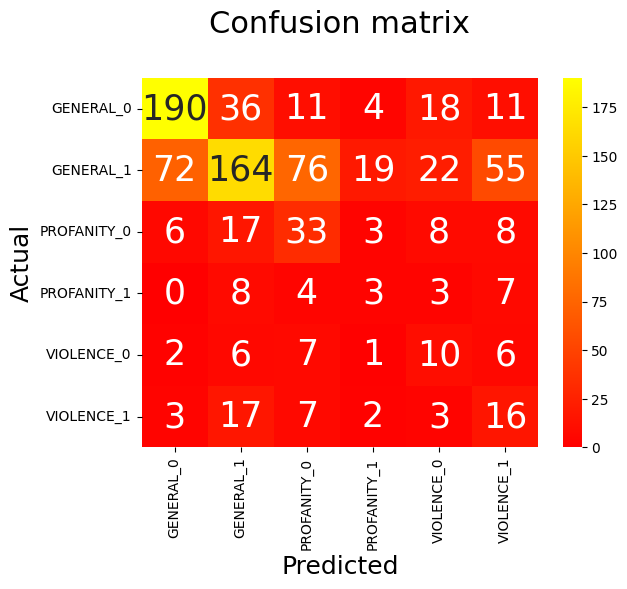

In [35]:
svc4 = SVC(probability=True, random_state=42)
svc4.fit(X_cnn_smote,y_cnn_smote)

# Scores of SVC2
svc4_pred=make_scores(svc4, X_test_unbal, y_test_unbal)

# Confusion Matrix for SVC2
make_confusion_matrix(y_test_unbal,svc4_pred)

## CNN and ADASYN

In [36]:
X_cnn_resampled_adasyn, y_cnn_resampled_adasyn=df_undersampled_cnn.drop(['Target'], axis=1), df_undersampled_cnn['Target']

# Define the sampling strategy for ADASYN
X_cnn_adasyn, y_cnn_adasyn = adasyn.fit_resample(X_cnn_resampled_adasyn, y_cnn_resampled_adasyn)

y_cnn_adasyn.value_counts()

Target
3    205
0    200
1    200
2    175
5    111
4     76
Name: count, dtype: int64

Accuracy :0.51981
AUC : 0.77972
Precision : 0.36690
Recall : 0.36568
F1 : 0.34569
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       270
           1       0.64      0.50      0.56       408
           2       0.25      0.41      0.31        75
           3       0.09      0.24      0.13        25
           4       0.36      0.12      0.19        32
           5       0.17      0.21      0.19        48

    accuracy                           0.52       858
   macro avg       0.37      0.37      0.35       858
weighted avg       0.57      0.52      0.54       858



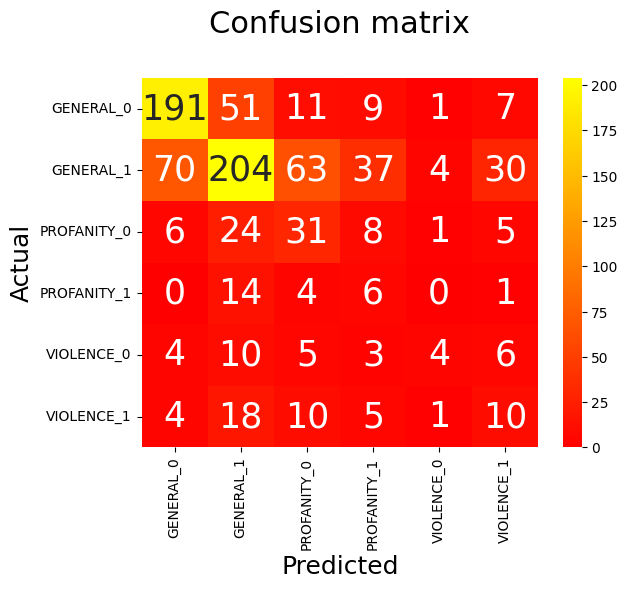

In [37]:
svc5 = SVC(probability=True, random_state=42)
svc5.fit(X_cnn_adasyn,y_cnn_adasyn)

# Scores of SVC2
svc5_pred=make_scores(svc5, X_test_unbal, y_test_unbal)

# Confusion Matrix for SVC2
make_confusion_matrix(y_test_unbal,svc5_pred)

Accuracy :0.45804
AUC : 0.65851
Precision : 0.27604
Recall : 0.28841
F1 : 0.26948
              precision    recall  f1-score   support

           0       0.61      0.71      0.66       270
           1       0.61      0.41      0.49       408
           2       0.16      0.35      0.22        75
           3       0.07      0.12      0.09        25
           4       0.12      0.06      0.08        32
           5       0.09      0.08      0.09        48

    accuracy                           0.46       858
   macro avg       0.28      0.29      0.27       858
weighted avg       0.51      0.46      0.47       858



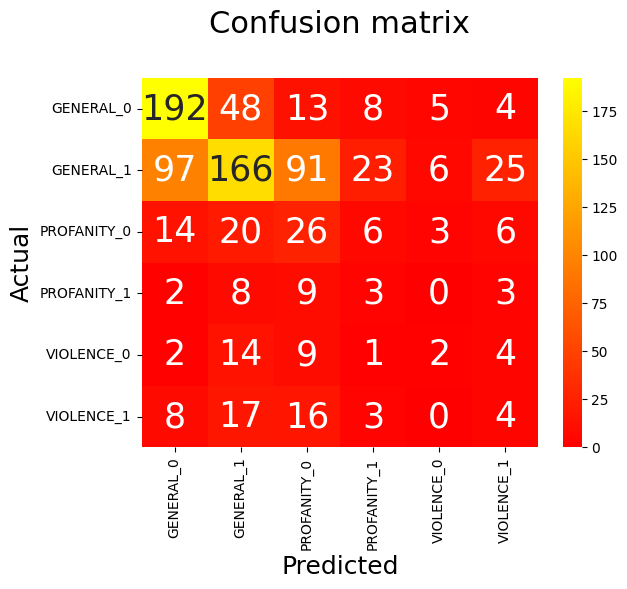

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_cnn_adasyn, y_cnn_adasyn)

# Make predictions
rf_pred = make_scores(rf, X_test_unbal, y_test_unbal)

# Confusion matrix
make_confusion_matrix(y_test_unbal, rf_pred)